# DEPENDENCIES FOR BNN USING VI
**Abbreviations**:

- ANN: Artificial Neural Network
- BNN: Bayesian Neural Network
- VI: Variational inference

# Necessary Imports

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchbnn as bnn
import matplotlib.pyplot as plt

# Loading the predefined synthetic regression problems:
if __name__ == '__main__':
    import import_ipynb
    N = import_ipynb.NotebookLoader(path=['.'])
    N.load_module('dependencies_for_data_generation')
    from dependencies_for_data_generation import *

importing Jupyter notebook from .\dependencies_for_data_generation.ipynb


# Globally Available Data

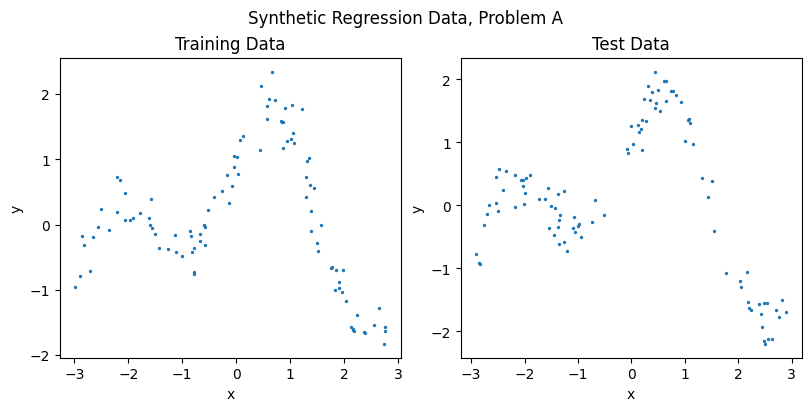

In [2]:
# Initialising data variables by generating a synthetic problem's data:
x_train, y_train, x_test, y_test = None, None, None, None
if __name__ == '__main__':
    x_train, y_train, x_test, y_test = generate_data('A')

# Defining the Bayesian Model and Loss Functions

In [6]:
class BNN:
    def __init__(self, prior_mu=0, prior_sigma=1, bayesian_layers='input, hidden, output', lr=0.01):
        # Storing certain parameters: for future reference:
        self.lr = lr
        self.prior_mu = prior_mu
        self.prior_sigma = prior_sigma
        self.bayesian_layers = bayesian_layers

        #------------------------------------
        # Building the model:
        input_layer, hidden_layer, output_layer = self.get_layers()
        self.model = nn.Sequential(input_layer, nn.ReLU(), hidden_layer, nn.ReLU(), output_layer)
    
        #------------------------------------
        # Defining the loss function and optimiser:
        
        # 1. Initialising MSE part of the loss function:
        self.mse_loss = nn.MSELoss()
        
        # 2. Initialising the KL divergence part of the loss function:
        self.kl_loss = bnn.BKLLoss(reduction='mean', last_layer_only=False)
        self.kl_weight = 0.01 # The weight given to the KL divergence part of the loss function
        
        # 3. Initialising the optimiser used for gradient descent:
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)

    #================================================
    # OBTAINING MODEL LAYERS AS SPECIFIED
    
    def get_layers(self):
        # Determining the input and output layers as Bayesian or non-Bayesian:
        if 'input' in self.bayesian_layers:
            input_layer = bnn.BayesLinear(prior_mu=self.prior_mu, prior_sigma=self.prior_sigma, in_features=1, out_features=50)
        else:
            input_layer = nn.Linear(in_features=1, out_features=50, bias=True)
        if 'hidden' in self.bayesian_layers:
            hidden_layer = bnn.BayesLinear(prior_mu=self.prior_mu, prior_sigma=self.prior_sigma, in_features=50, out_features=50)
        else:
            hidden_layer = nn.Linear(in_features=50, out_features=50, bias=True)
        if 'output' in self.bayesian_layers:
            output_layer = bnn.BayesLinear(prior_mu=self.prior_mu, prior_sigma=self.prior_sigma, in_features=50, out_features=1)
        else:
            output_layer = nn.Linear(in_features=50, out_features=1, bias=True)

        return input_layer, hidden_layer, output_layer
    
    #================================================
    # WRAPPER FOR THE MODEL'S FORWARD FUNCTION

    def predict(self, x):
        # If data is in NumPy array form, convert to PyTorch tensors:
        if isinstance(x, np.ndarray): x = torch.tensor(x)
        return self.model(x).detach().numpy() # Returning as a NumPy array for convenience
        '''NOTE: Use of `.detach`:
        `.detach` is used because the return value of `self.model(x)` is a tensor that requires grad,
        and such a tensor cannot be converted to a NumPy array using `.numpy`.
        However, using `.detach` creates another tensor with the same values but which does not require grad.
        '''
    
    #================================================
    # TRAINING LOOP
    
    def enhanced_fit(self, x, y, epochs=30, batch_size=2, num_reinitializations=1, problem_id=None):
        # NOTE: `problem_id` helps name the files of the stored model weights
        
        # If data is in NumPy array form, convert to PyTorch tensors:
        if isinstance(x, np.ndarray): x = torch.tensor(x)
        if isinstance(y, np.ndarray): y = torch.tensor(y)

        #------------------------------------
        # Initialising data loader to enable batch training:
        data = list(zip(x, y))
        data_loader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=False)

        #------------------------------------
        best_model, best_model_cost = self.model, float('inf')
        for i in range(num_reinitializations):
            min_avg_cost = float('inf')
            #________________________
            # Training loop:
            for epoch in range(epochs):
                avg_cost = 0
                # Per-epoch training loop:
                #............
                for data in data_loader:
                    x_batch, y_batch = data
                    
                    # Obtaining the model's predicted values for the inputs:
                    prediction = self.model(x_batch)
                
                    # Calculating the loss function:
                    mse = self.mse_loss(prediction, y_batch)
                    kl = self.kl_loss(self.model)
                    cost = mse + self.kl_weight*kl
                    avg_cost += float(cost)
                    
                    # Optimisation step:
                    self.optimizer.zero_grad() # Resetting the optimiser's gradients
                    cost.backward() # Calculating the gradients for backpropagation
                    self.optimizer.step() # Applying the gradients for backpropagation
                #............
                # If the last epoch's average cost were lower than the minimum so far, save the weights of the model so far:
                if avg_cost < min_avg_cost:
                    min_avg_cost = avg_cost
                    torch.save({'model_state_dict': self.model.state_dict()}, f'storage/vi_bnn--problem_{problem_id}--weights.pth')
            #________________________
            # Assign the best performing model weights (as decided with respect to average cost):
            if min_avg_cost < best_model_cost:
                best_model_cost = min_avg_cost
                best_model.load_state_dict(torch.load(f'storage/vi_bnn--problem_{problem_id}--weights.pth')['model_state_dict'])
            #________________________
            # Reinitialising the model for the next run:
            input_layer, hidden_layer, output_layer = self.get_layers()
            self.model = nn.Sequential(input_layer, nn.ReLU(), hidden_layer, nn.ReLU(), output_layer)
            # Defining the loss function and optimiser:
            self.mse_loss = nn.MSELoss()
            self.kl_loss = bnn.BKLLoss(reduction='mean', last_layer_only=False)
            self.optimizer = optim.Adam(self.model.parameters(), lr=self.lr)
        
        #------------------------------------
        # Assigning `best_model` to `self.model`:
        self.model = best_model

> **Reference**:
> 
> - [_Save your Model’s weights_ (PyTorch) by 
Mohit Dulani ffrom**Medium.com**](https://medium.com/@mohitdulani/save-your-models-weights-ee457d368637)
> - [_Training a PyTorch Model with DataLoader and Dataset_ by Adrian Tam from **MachineLearningMastery.com**](https://machinelearningmastery.com/training-a-pytorch-model-with-dataloader-and-dataset/) 

# Training BNN and Presenting the Results

In [7]:
vi_bnn = BNN(bayesian_layers='hidden')
if __name__ == '__main__':
    vi_bnn.enhanced_fit(x_train, y_train, epochs=30)

Plotting the results (plotting functions packaged as a function for reusability)...

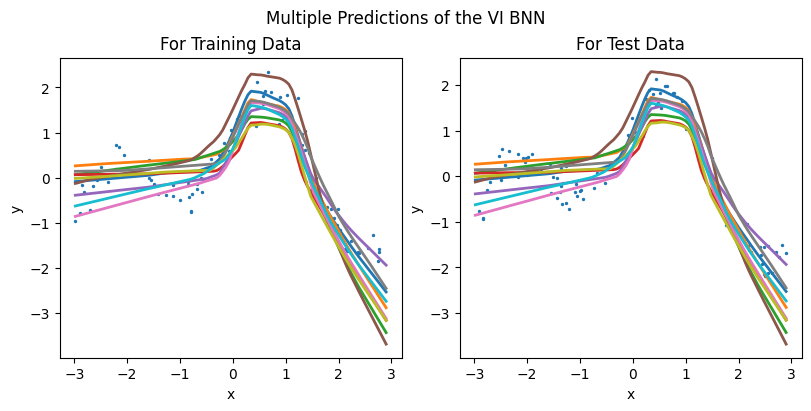

In [8]:
def plot_vi_results(vi_bnn, x_train, y_train, x_test, y_test, samples_to_show=3, show_suptitle=True):
    fig, axs = plt.subplots(1, 2, constrained_layout=True, figsize=(8, 4))
    min_x = min(min(x_train), min(x_test))
    max_x = max(max(x_train), max(x_test))
    x = np.linspace(min_x, max_x, 100)
    y_predictions = []
    
    #------------------------------------
    # Plotting the training data:
    axs[0].scatter(x_train, y_train, s=2, label='Train Data')
    for i in range(samples_to_show):
        y_predictions.append(vi_bnn.predict(x))
        # NOTE 1: The above stores the prediction for the model parametrisations
        # NOTE 2: This helps compare the training and test performance for the same model parametrisations
        axs[0].plot(x, y_predictions[-1], linewidth=2)
    # Final formatting for the plot:
    axs[0].set_title('For Training Data')
    axs[0].set_xlabel('x')
    axs[0].set_ylabel('y')

    #------------------------------------
    # Plotting the test data:
    plt.scatter(x_test, y_test, s=2, label='Test Data') 
    for y_prediction in y_predictions:
        plt.plot(x, y_prediction, linewidth=2)
    # Final formatting for the plot:
    axs[1].set_title('For Test Data')
    axs[1].set_xlabel('x')
    axs[1].set_ylabel('y')

    #------------------------------------
    if show_suptitle:
        plt.suptitle('Multiple Predictions of the VI BNN')
    plt.show()

if __name__ == '__main__':
    plot_vi_results(vi_bnn, x_train, y_train, x_test, y_test, samples_to_show=10)